In [1]:
#%matplotlib widget
from time import time
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage
from itertools import islice

In [6]:


def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)    

In [8]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tile(im, nrows=1, ncolumns=6):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for y in range(0,N*ncolumns,N):
        row = []
        for x in range(0,M*nrows,M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    return rows

flatten = lambda l: [item for sublist in l for item in sublist]

def via_variance_of_laplacian(image):
    tiles = tile(image, 8, 20)
    return [variance_of_laplacian(i) for i in flatten(tiles)]

In [21]:
# Optical Flow Based
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

def via_lk_optical_flow(im, last_im, debugging=False):

    
    # params for ShiTomasi corner detection
    feature_params = dict(
        maxCorners = 100,
        qualityLevel = 0.007,
        minDistance = 20,
        blockSize = 9,
        #useHarrisDetector = True,
        )

    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (15,15),
        maxLevel = 1,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
        )
    
    p0 = cv2.goodFeaturesToTrack(last_im, mask = None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(last_im, im, p0, None, **lk_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(last_im)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    
    # setup zenith
    shape=im.shape
    #ys,xs = np.indices(shape)
    x_offset = shape[1] // 2
    y_offset = int(originy)
    
    img = im.copy()

    df = pd.DataFrame()
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        
        dx, dy = (x2-x1), (y2-y1)
        if dx == 0.0:
            dx = 0.00001 #prevent divide by zero
        Vf_slope = dy/dx
        Vf_mag = (dx**2 + dy**2)**0.5
        
        if Vf_mag < 3 or Vf_mag>120:
            #not moved enough
            continue

        df.loc[i,'|Vf|'] = Vf_mag
        df.loc[i,'Vf_slope'] = Vf_slope
        
        right_direction = y2>y1 and abs(Vf_slope) > 3 # down and steep
        df.loc[i,'right_direction'] = right_direction
        
        if right_direction:
            color=255
            df.loc[i,'good'] = True
        else:
            color=130
            df.loc[i,'good'] = False
        
        if debugging:
            img = cv2.arrowedLine(img, (int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
            img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    
    if len(df) != 0:
        # filter out noisy "small" flow vectors
        Vf_max = df[df['good']==True]['|Vf|'].max()
        df.loc[df['|Vf|']<Vf_max*.45,'good'] = False
    
    if debugging:
        if len(df) == 0:
            print("no useful points")
        else:
            display(df.sort_values(by='|Vf|'))       
            bins = list(range(0,101,10))
            plt.rcParams['figure.figsize'] = [20, 5]
            df['|Vf|'].hist(bins=bins)
            df[df['good']==True]['|Vf|'].hist(bins=bins)
            plt.show()

        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(img)
        plt.show()

    if len(df) == 0:
        return [np.nan, np.nan]
    else:
        return [
            df.loc[df['good'],'|Vf|'].mean(),
            df.loc[df['right_direction'],'|Vf|'].std(),
            ]


In [93]:
# Process frames
def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            yield image
        else:
            return

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def crop_frames(frames):
    for f in frames:
        yield crop(f)

def bw_frames(frames):
    for f in frames:
        yield cv2.cvtColor(f,cv2.COLOR_BGR2GRAY)

def perspec_frames(frames):
    for f in frames:
        yield fix_perspective(f)
        
def diff_frames(frames):
    from skimage.measure import compare_ssim
    for a, b in frames:
        (score, diff) = compare_ssim(grayA, grayB, full=True)
        diff = (diff * 255).astype("uint8")
    yield diff
    

def adjacent(frames):
    # yields i(n), i(n-1)
    # repeats at the end to keep length len
    last_x = None
    for x in frames:
        if last_x is not None:
            yield x, last_x
        last_x = x
    yield x, last_x

def view_frames(frames):
    for f in frames:
        if isinstance(f, tuple):
            images = list(f)
        else:
            images = [f]

        for i, image in enumerate(images):
            cv2.imshow(f'f{i}',image)
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f

class FeatureExtractor():
    def __init__(self, frames_generator_maker):
        self._frames = frames_generator_maker
        self._steps = []
    def add_step(self, step):
        if callable(step):
            self._steps.append(step)
    def __iter__(self):
        pipeline = self._frames()
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline
    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self.start)/60:2.1f} minutes")
    def extract_features(self):
        self._start = time()
        self._last = self._start
        X = []
        for i, (im, last_im) in enumerate(self):
            xs = []
            
            xs += via_lk_optical_flow(im, last_im)
            xs += via_variance_of_laplacian(im)
            
            self._pprogress(i)
        self._pprogress(i,True)
        
        return X


In [94]:
fe = FeatureExtractor(frames)
fe.add_step(lambda g: islice(g, 0, 20400, 10)) # limit frames (start, stop, step)
fe.add_step(crop_frames)
fe.add_step(bw_frames)
fe.add_step(perspec_frames)
fe.add_step(adjacent)
fe.add_step(diff_frames)
fe.add_step(view_frames)

xs = fe.extract_features()

ModuleNotFoundError: No module named 'skimage'

In [786]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.fillna(method='pad', inplace=True)

Xy = X.copy(deep=True)
Xy['y'] = y

chunksize = 60
chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,0,1,y
4896,40.500292,7.669771,22.440544
4897,34.197536,5.068116,22.424016
4898,51.412717,11.553860,22.434915
4899,43.261816,8.649379,22.434986
4900,37.810950,3.750461,22.416519
...,...,...,...
15907,34.203655,4.178510,1.635597
15908,30.421263,3.743839,1.669785
15909,15.155831,3.002027,1.585380
15910,19.513273,6.555173,1.517044


In [787]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [789]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

m_ensemble = StackingRegressor([
   ('svr', SVR(C=20)),
   ('rf', RandomForestRegressor()),
   ('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
   ])

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=False, include_bias=False)),
    #'reduce_dims', PCA(n_components=4)),
    #'svr', SVR(C=20)),
    #('rf', RandomForestRegressor()),
    #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
    #('br', BayesianRidge()),
    #('stack', m_ensemble),
    ('lin', LinearRegression()),
    ])



# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    #'svr__C':[.01, .1, .3, .9, 2, 4, 10, 20],
    #'svr__C':[10, 20, 30, 40, 70, 120],
    'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],RandomForestRegressor
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=5, cv=5)

m_real = pipe


In [790]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('lin', LinearRegression())])


In [813]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [814]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.00035]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
kf_tuned = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [815]:
# never below 0
Xy2.loc[Xy2['pred']<0.0,'pred'] = 0.0

In [816]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf_tuned.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [817]:
Xy2

,0,1,y,is_test,dum,pred,pred_kf
0,58.673446,8.102813,28.105569,True,13.146995,22.890521,20.892288
1,59.147177,9.253941,28.105569,True,13.146995,22.849532,20.898901
2,55.560619,11.636454,28.106527,True,13.146995,21.968342,20.904831
3,73.675072,17.584648,28.130404,True,13.146995,22.952491,20.910389
4,35.566856,7.167218,28.109243,True,13.146995,17.210334,20.915232
...,...,...,...,...,...,...,...
20395,7.681011,2.117290,2.329180,False,13.146995,3.608653,NaN
20396,9.685960,2.550483,2.289795,False,13.146995,4.802073,NaN
20397,31.417940,2.550483,2.292917,False,13.146995,17.154689,NaN
20398,5.376523,1.456416,2.260600,False,13.146995,2.303986,NaN


In [818]:
Xy2['0_kf'] = kf_tuned.smooth(Xy2[0].values)[0]
Xy2['0_kf'] *= Xy2['y'].mean()/Xy2['0_kf'].mean()

Xy2['1_kf'] = kf_tuned.smooth(Xy2[1].values)[0]

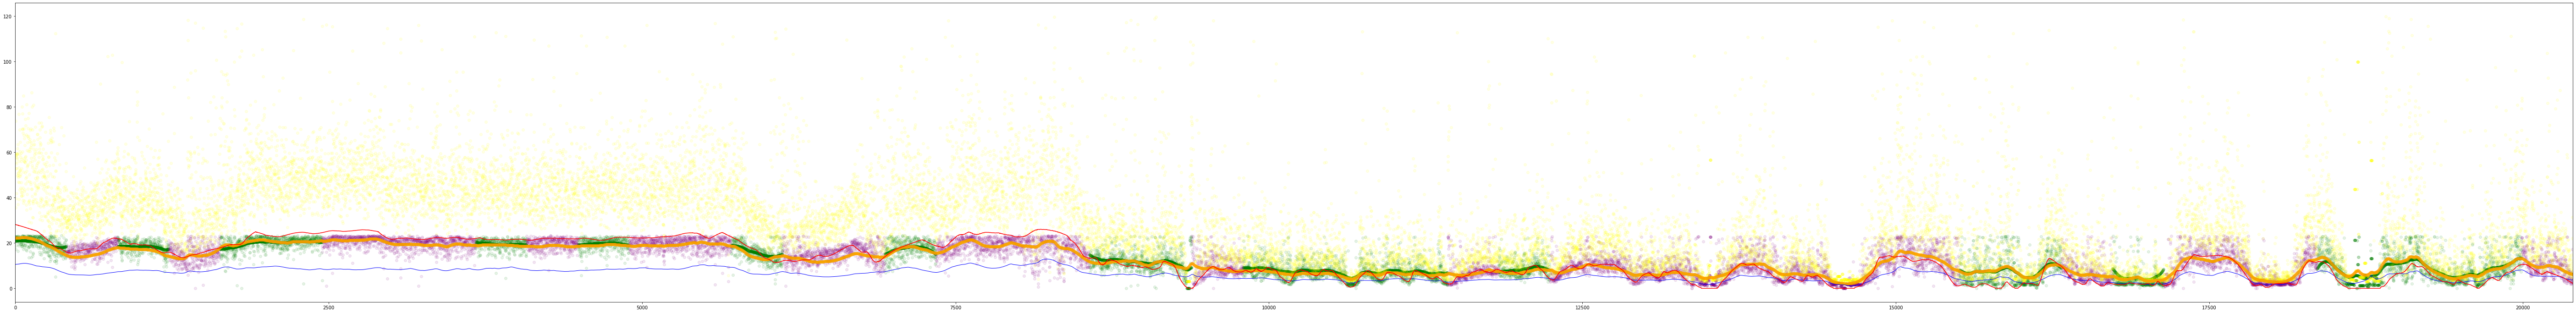

In [821]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    if ix_mask is None:
        df = Xy2.loc[:,column]
    else:
        df = Xy2.loc[ix_mask, column]
    plt.plot(df.index, df.values, **kwargs)
    
plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, 0, marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_Xy2(None, '0_kf', marker='o', linewidth=0.0, color='orange', alpha=.1)
plot_Xy2(None, '1_kf', marker='', linewidth=1.0, color='blue')
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')

In [820]:
def print_summary_line(ix_mask, column='dum'):
    if ix_mask is not None:
        Xy = Xy2[ix_mask]
    else:
        Xy = Xy2
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end=' ')

print(f"dummy test train test_kf")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')

dummy test train test_kf
71.6 24.6 22.5 11.2 